In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append('./sailfish/')

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")


# Fala zaburzenia w LBM

Zaburzenie w modelu siatkowym porusza się z tak zwaną sieciową prędkością dźwięku. Dla modelu `D2Q9` wynosi ona:

$$ c_s = \frac{1}{\sqrt 3}$$

Poniższy kod symuluje ewolucję zaburzenia gęstości w cieczy znajdującej się wewnątrz kwadratowego obszaru ze ściankami (noslip):

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hy == self.gy-1) & (hx == self.gx-1) &(hx==0)&(hy==0)  )  
        self.set_node(wall_map, NTFullBBWall)

Warunkiem początkowym jest $v_x=0$, $v_y=0$ (domyślnie wszysktkie pola makroskopowe są zerowane). Ciecz ma w chwili początkowej stałą gęstość $\rho=1$ z wyjątkiem węzła `32,1` w którym mamy $\rho=1.1$:
    
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        sim.rho[32,1] = 1.1  

Możemy się spodziewać fali zaburzenia rozchodzącej się w prawo. W celu zapisu przebiegu tego zdarzenia zapisujemy pola makroskopowe po każdym kroku symulacji: `--every=1`.

### Wykonaj:

1. Uruchom kod symulacji. Upewnij się czy dane wynikowe się zapisały w podkatalogu `data`
2. Wykonaj kod w notatniku wizualizujący przebieg symulacji. 
3. Zaobserwuj rozchodzenie się fali dzwiękowej. Oszacuj wizualnie jej prędkość w jednostkach sieci na iteracje.
4. Zmień numeryczną lepkość przez modyfikacji parametru `--visc` od $0.1$ do $0.001$. Czy prędkość dźwięku zmienia się ? Jakie są różnice w wynikach?
5. (*) Oblicz numerycznie prędkość fali obliczając położenie pierwszego maksimum przekroju `[32,:]` dla każdej iteracji. Porównaj z wartością teoretyczną dla różnych $\mu_{LB}$.






In [2]:
%%writefile data/ex5.py

import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hy == self.gy-1) & (hx == self.gx-1) &(hx==0)&(hy==0)  )  
        self.set_node(wall_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        sim.rho[32,1] = 1.1
        
class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Writing data/ex5.py


In [3]:
%%sh
export PYTHONPATH=$PWD/sailfish/
python data/ex5.py --max_iters=100 --every=1 \
 --lat_nx=63 --lat_ny=63 \
 --model=mrt \
 --visc=0.1 \
 --output=./data/ex5 --output_format=npy

[  1678  INFO Master/GPU3] Machine master starting with PID 111495 at 2016-06-07 22:02:08 UTC
[  1678  INFO Master/GPU3] Simulation started with: data/ex5.py --max_iters=100 --every=1 --lat_nx=63 --lat_ny=63 --model=mrt --visc=0.1 --output=./data/ex5 --output_format=npy
[  1743  INFO Master/GPU3] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[  1743  INFO Master/GPU3] Handling subdomains: [0]
[  1743  INFO Master/GPU3] Subdomain -> GPU map: {0: 0}
[  1744  INFO Master/GPU3] Selected backend: cuda
[  6127  INFO Subdomain/0] Initializing subdomain.
[  6129  INFO Subdomain/0] Required memory: 
[  6129  INFO Subdomain/0] . distributions: 0 MiB
[  6129  INFO Subdomain/0] . fields: 0 MiB
[ 11290  INFO Subdomain/0] Starting simulation.
[ 13005  INFO Subdomain/0] Simulation completed after 100 iterations.


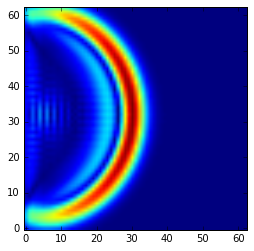

In [4]:
data = np.load("data/ex5.0.050.npz")
vx,vy = data['v']
rho = data['rho']
plt.imshow(np.sqrt(vy**2+vx**2),origin='top')

Rho 0.999865 1.00029


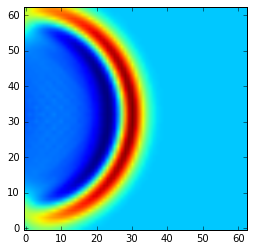

In [5]:
print "Rho",np.nanmin(rho),np.nanmax(rho)
plt.imshow(rho,origin='top')

In [6]:
import glob
frames = []

for fn in sorted(glob.glob("data/ex5*.npz")):
    data = np.load(fn)
    vx,vy = data['v']
    rho = data['rho']
    #vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,rho])
print "Read ",(len(frames)),"files"

Read  101 files


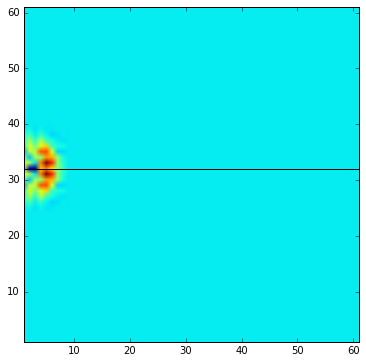

In [9]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
#from IPython.display import display,clear_output
ny,nx = frames[0][0].shape
@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=6),\
          sel=widgets.Dropdown(options=[('vx',0),('vy' , 1), ('rot v', 2),('rho',3)],value=0))
def g(ith,figsize,sel):
    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')
    plt.axhline(y=32, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show()

### Wyznaczanie prędkości dźwięku

`np.argmax` pozwala znaleźć indeks maksymalnego elementu tablicy. Można ją wykorzystać do śledzenia fali zaburzenia, zauważając, że pierwsze maksimum jest maksimum globalnym.

In [ ]:
ith = 35
f_ = frames[ith]
imax = np.argmax(f_[3][32,:])
plt.plot(f_[3][32,:])
plt.plot( imax,f_[3][32,imax],'ro')